<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/ClassificationProblemClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Raccattare le immagini

In [1]:
# Github Max immagini 500Mb
# Saper clonare un repositorio da github --> git clone
# Speech to text
#!unzip  covid-mask-classifier-master.zip -d ciao/
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

Cloning into 'covid-mask-classifier'...
remote: Enumerating objects: 1084, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1084 (delta 26), reused 15 (delta 3), pack-reused 1013
Receiving objects: 100% (1084/1084), 89.00 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (27/27), done.


## Train Test set

In [2]:
# Entra dentro la cartella mask 
# dammi tutti i nomi
# prendi 100 nomi e caso
# copia queste 100 immagini in una cartella test
# copia tutte le altre nella cartella train
#!rm -rf /content/covid-mask-classifier/dataset/train
#!rm -rf /content/covid-mask-classifier/dataset/test
#!rm /content/covid-mask-classifier/dataset/test/*.jpeg

In [3]:
import os
import random
import shutil
classes = ["mask","no-mask"]
for cl in classes:
  path2images = "covid-mask-classifier/dataset/" + cl
  train_save_path = "covid-mask-classifier/dataset/train/" + cl
  test_save_path = "covid-mask-classifier/dataset/test/" + cl
  if not os.path.exists(train_save_path):
    os.makedirs(train_save_path)
  if not os.path.exists(test_save_path):
    os.makedirs(test_save_path)
  names = os.listdir(path2images)
  test_names = random.sample(names, 100)
  for name in test_names:
    read = os.path.join(path2images,name)  
    write = os.path.join(test_save_path,name)  
    shutil.copy(read,write)
  for name in names:
    if name not in test_names:
      read = os.path.join(path2images,name)  
      write = os.path.join(train_save_path,name)  
      shutil.copy(read,write)
# len(os.listdir("/content/covid-mask-classifier/dataset/train/mask"))

## Dataset

torch.Size([32, 3, 256, 256]) tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1])


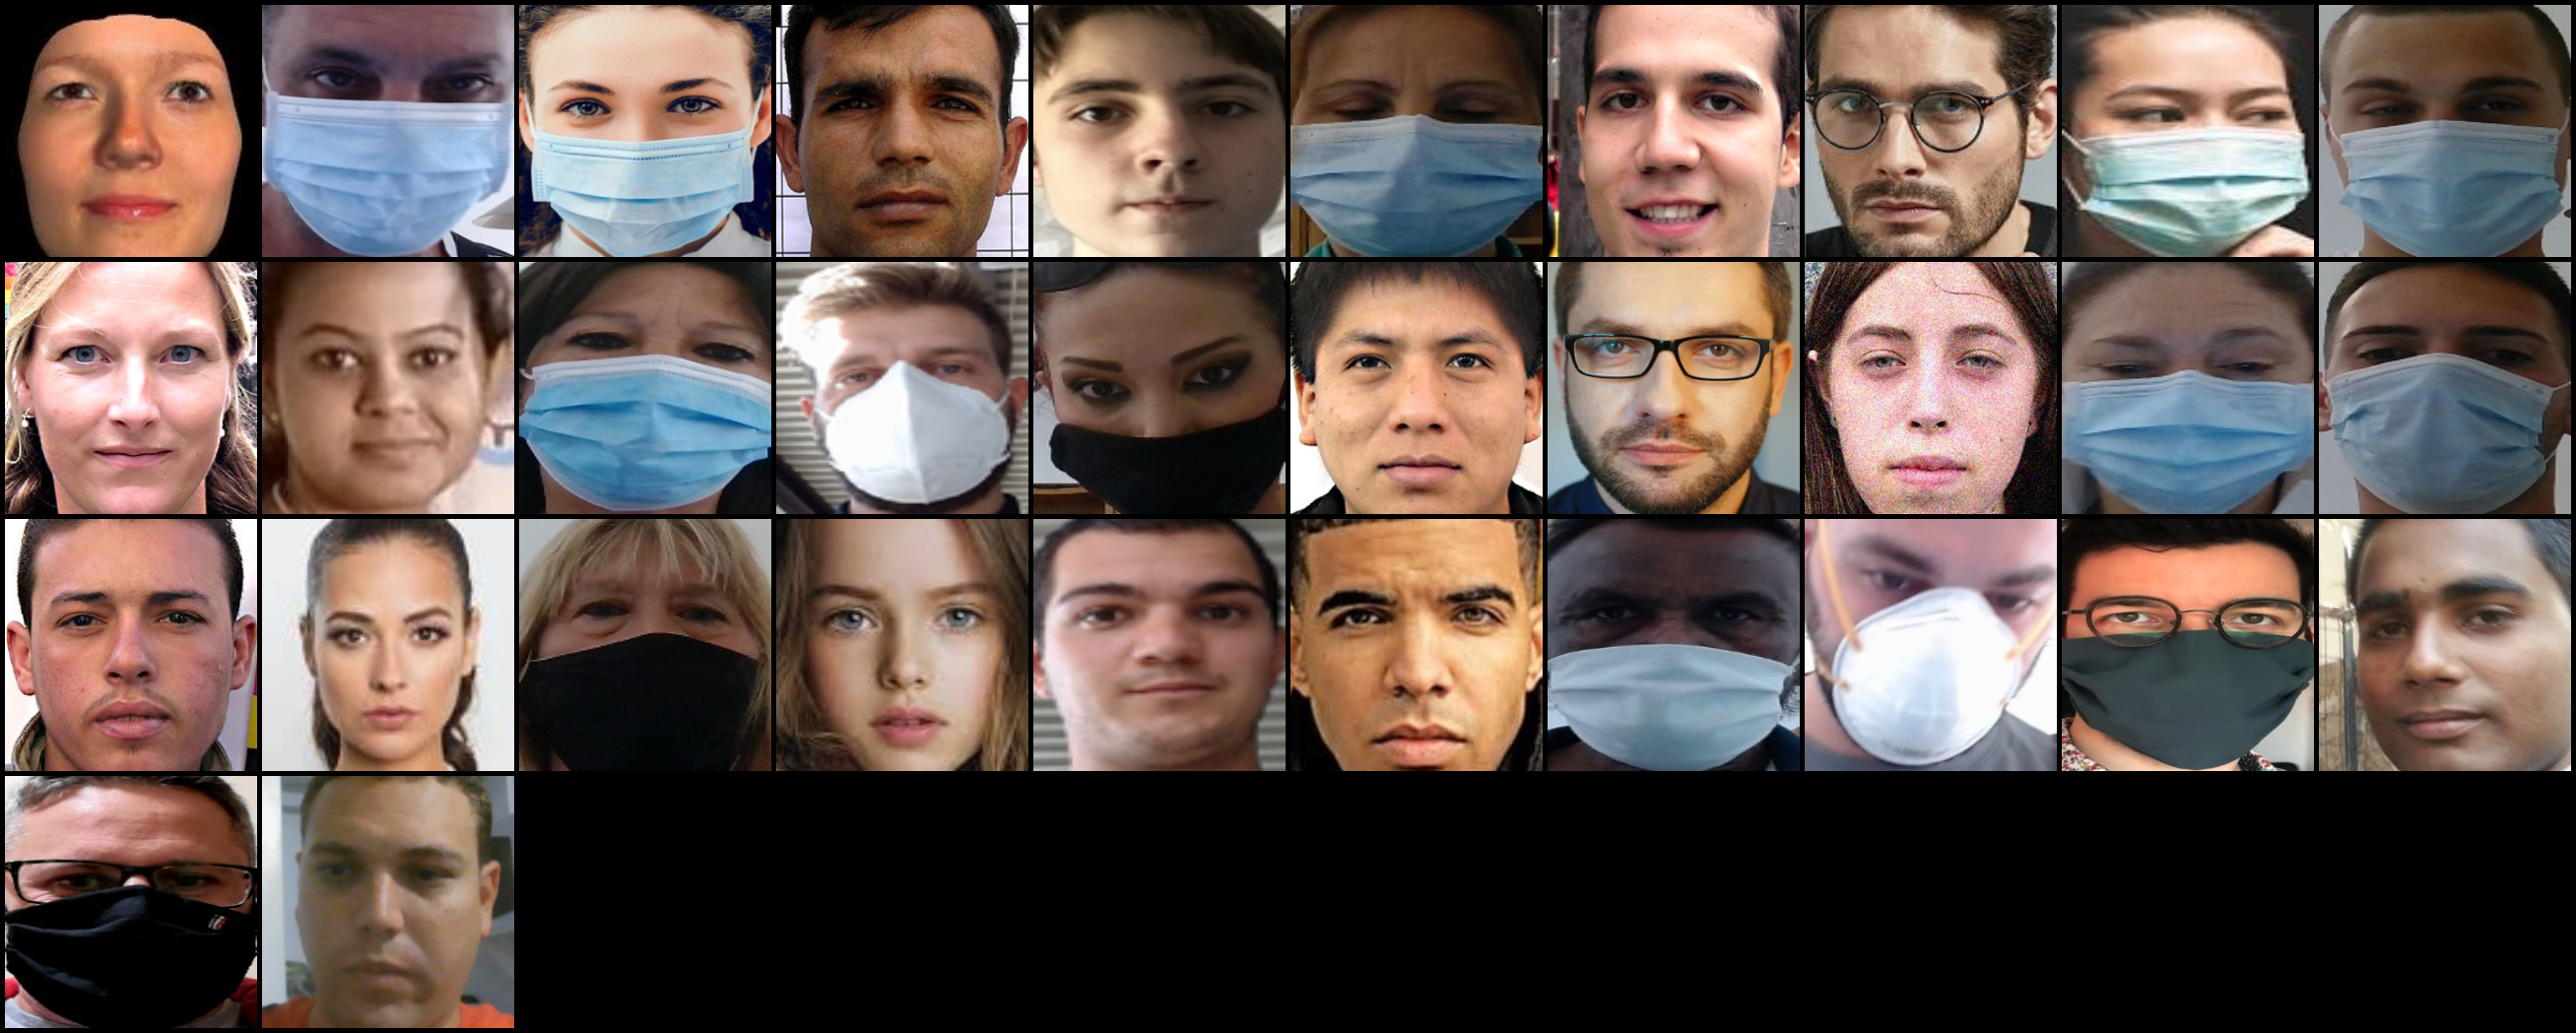

In [4]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch
from torchvision import transforms
import torchvision

class ImageDataset(Dataset):
    def __init__(self, folder_path,classes):
        names = os.listdir(folder_path) 
        self.filepaths = []
        self.y = []
        for c in classes.keys():
            folder_class = os.path.join(folder_path,c)
            names = os.listdir(folder_class)
            f = [os.path.join(folder_path,c,name) for name in names]
            self.filepaths.extend(f)
            self.y.extend([classes[c] for i in range(0,len(f))])
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        y = self.y[index]
        x = Image.open(filepath).convert("RGB")
        
        x = transforms.Resize((256,256))(x)
        x = transforms.ToTensor()(x)
        return x,y
    def __len__(self):
        return len(self.filepaths)

classes = {'mask': 0, 'no-mask': 1}
train_path = "/content/covid-mask-classifier/dataset/train"
test_path = "/content/covid-mask-classifier/dataset/test"

train_ds = ImageDataset(train_path,classes)
test_ds = ImageDataset(test_path,classes)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=32,shuffle=True)
test_dl = torch.utils.data.DataLoader(train_ds,batch_size=32,shuffle=True)

for x,y in train_dl:
  print(x.shape,y)
  batch_grid =torchvision.utils.make_grid(x, nrow=10, padding=5)
  display( transforms.ToPILImage()(batch_grid) )
  break

## Design neural network

In [ ]:
from torch import nn
class MyNet(nn.Module):

    def __init__(self):
        super(MyNet, self).__init__()
        # 32 64 128 256
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
       
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 16 * 16, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
       
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = torch.relu(self.conv3(x))
        x = self.pool3(x)

        x = torch.relu(self.conv4(x))
        x = self.pool4(x)

        x = x.reshape(-1, 256*16*16)
        x = torch.relu( self.fc1(x) )
        x = self.fc2(x)
        x = torch.log_softmax( x , dim=-1)

        return x

net = MyNet()
for x,y in train_dl:
  y = net(x)
  print(y)
  break

## PIpeline Training

In [6]:
from torch import optim
from sklearn.metrics import confusion_matrix
import numpy as np
import copy

# validation: metric regression
def metrics_func_regression(target, output):
    # Comptue mean squaer error (Migliora quanto piu' ci avviciniamo a zero)
    mse = torch.sum((output - target) ** 2)
    return mse

# validation metric classification
def metrics_func_classification(target, output):
    # Compute number of correct prediction
    pred = output.argmax(dim=-1,keepdim=True)
    corrects =pred.eq(target.reshape(pred.shape)).sum().item()
    return -corrects # minus for coeherence with best result is the most negative one

# training: loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric 
    with torch.no_grad():
        metric_b = metric_func(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b

# one epoch training
def loss_epoch(model, loss_func,metric_func, dataset_dl, sanity_check,opt, device):
    loss = 0.0
    metric = 0.0
    len_data = float(len(dataset_dl.dataset))
    # get batch data
    for xb,yb in dataset_dl:    
        # send to cuda the data (batch size)
        xb = xb.to(device)
        yb = yb.to(device)
        # obtain model output 
        yb_h = model.forward(xb)
        # loss and metric Calculation
        loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
        # update loss
        loss += loss_b
        # update metric
        if metric_b is not None:
            metric+=metric_b 
        if sanity_check is True:
            break
    # average loss
    loss /=len_data
    # average metric
    metric /=len_data
    return loss, metric

# get learning rate from optimizer
def get_lr(opt):
    # opt.param_groups[0]['lr']
    for param_group in opt.param_groups:
        return param_group["lr"]

# trainig - test loop
def train_test(params):
    # --> extract params
    model = params["model"]
    loss_func=params["loss_func"]
    metric_func=params["metric_func"]
    num_epochs=params["num_epochs"]
    opt=params["optimizer"]
    lr_scheduler=params["lr_scheduler"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    device=params["device"]
    continue_training=params["continue_training"]
    sanity_check=params["sanity_check"]
    path2weigths=params["path2weigths"]
    # --> send model to device and print device
    model = model.to(device)
    print("--> training device %s" % (device))
    # --> if continue_training=True load path2weigths
    if continue_training==True and os.path.isfile(path2weigths):
        print("--> continue training  from last best weights")
        weights = torch.load(path2weigths)
        model.load_state_dict(weights)
    # --> history of loss values in each epoch
    loss_history={"train": [],"test":[]}
    # --> history of metric values in each epoch
    metric_history={"train": [],"test":[]}
    # --> a deep copy of weights for the best performing model
    best_model_weights = copy.deepcopy(model.state_dict())
    # --> initialiaze best loss to large value
    best_loss=float("inf")
    # --> main loop
    for epoch in range(num_epochs):
        # --> get learning rate
        lr = get_lr(opt)
        print("----\nEpoch %s/%s, lr=%.6f" % (epoch+1,num_epochs,lr))
        # --> train model on training dataset
        # we tell to the model to enter in train state. it is important because
        # there are somelayers like dropout, batchnorm that behaves 
        # differently between train and test
        model.train()
        train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl,sanity_check, opt,device)
        # --> collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # --> tell the model to be in test (validation) mode
        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, metric_func, test_dl,sanity_check,opt=None,device=device)
        # --> collect loss and metric for test dataset
        loss_history["test"].append(test_loss)
        metric_history["test"].append(test_metric)
        # --> store best model
        if test_loss < best_loss:
            print("--> model improved! --> saved to %s" %(path2weigths))
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            # --> store weights into local file
            torch.save(model.state_dict(),path2weigths)
        # --> learning rate scheduler
        lr_scheduler.step()
        print("--> train_loss: %.6f, test_loss: %.6f, train_metric: %.3f, test_metric: %.3f" % (train_loss,test_loss,train_metric,test_metric))
    # --> load best weights
    model.load_state_dict(best_model_weights)
    return model, loss_history,metric_history

# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
model = MyNet()
opt = optim.Adam(model.parameters(),lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999)  #  lr = lr * gamma ** last_epoch
params = {
    "model":                 model,
    "loss_func":             nn.NLLLoss(reduction="sum"), 
    "metric_func":           metrics_func_classification,
    "num_epochs":            5,
    "optimizer":             opt,
    "lr_scheduler":          lr_scheduler,
    "train_dl":              train_dl,
    "test_dl":               test_dl,
    "device":                device,  
    "continue_training" :    False,  # continue training from last save weights
    "sanity_check":          False, # if true we only do one batch per epoch
    "path2weigths":          "./best_model.pt"  
} 
model, loss_history,metric_history = train_test(params)      

--> training device cuda:0
----
Epoch 1/5, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.642099, test_loss: 0.445218, train_metric: -0.636, test_metric: -0.939
----
Epoch 2/5, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.232323, test_loss: 0.091351, train_metric: -0.932, test_metric: -0.976
----
Epoch 3/5, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.086967, test_loss: 0.056054, train_metric: -0.971, test_metric: -0.986
----
Epoch 4/5, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.053155, test_loss: 0.041841, train_metric: -0.982, test_metric: -0.989
----
Epoch 5/5, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.047905, test_loss: 0.036095, train_metric: -0.982, test_metric: -0.990


## Test Produzione

mask


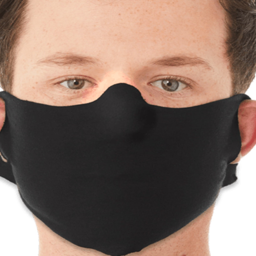

In [7]:
from PIL import Image
# Read Image
def preprocess_image(filepath,size=256):
    #filepath = os.path.join("covid-mask-classifier","dataset","mask","5e7cded7ba85ee690669c204.jpg")
    im_pil = Image.open(filepath).convert("RGB").resize((256,256))
    im_tensor = transforms.ToTensor()( im_pil ).unsqueeze(0)
    return im_tensor  #, im_pil

# Load Model
device = torch.device("cpu")
classes = {'mask':0, 'no-mask':1}
class_name =  list(classes.keys())
net = MyNet().to(device)
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)
size  = 256 # Training size shape

# Tell the model layer that we are going to use the model in evaluation  mode!
net.eval()

im_tensor = preprocess_image("/content/covid-mask-classifier/dataset/mask/2020-04_GQ_Face-Masks_3x2-7.jpg",256)
with torch.no_grad():
  out = net.forward(im_tensor).argmax(dim=-1,keepdim=True).item()
  print(class_name[out])
  display(transforms.ToPILImage()(im_tensor[0]))


## Scatta una foto

In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))